# Visual Inspection of Blade Tools - Loris Giannatempo

### The plan:
- binarize and extract the contours and keep only the side of the blade with the teeth to inspect
- approximate the contour curve to a set of small segments using [Ramer-Douglas-Peucker algorithm](https://en.m.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm)
- filter segments shorter than a certain threshold to select only the rectilinear components of the teeth
- apply some logic to label segments as belonging to one specific tooth
- for each teeth side find the line that best fits among the points
- calculate the angles between the line approximating teeth sides

## Import needed libraries and open the image

Recommended library versions:
- markupsafe==2.0.1
- numpy==1.19.5
- matplotlib==3.3.4
- jupyter==1.0.0
- opencv-python==3.4.2.16
- opencv-contrib-python==3.4.2.16

In [143]:
%matplotlib inline
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
# Only for jupyter notebook visualization
%matplotlib inline

# READ IMAGE
imgNum = '07'
img = cv2.imread('img/saw_pictures/saw_'+imgNum+'.png', cv2.IMREAD_GRAYSCALE)

#DEFINE SOME PARAMETER THAT WILL BE USED FOR THIS PROCESSING PIPELINE
APPROX_POLY_DP_EPSILON=3 #Tollerance for Ramer-Douglas-Peucker: the lower the value, the more the number of lines that will be used to approximate non rectilinear features
TEETH_SEGMENT_LEN_THRESH=40 #Length threshold for filtering segments belonging to arcs


## Contour Extraction
The image is taken using backlighting, so it's inherently binary. So we use an automatic thresholding technique taking advantage of the [*cv2.threshold()*](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57) function.
I tested both the triangle algorithm (cv.THRESH_TRIANGLE) and the Otzu algorithm (cv.THRESH_OTSU). Otsu gave better results & reliability (see [triangle_method_binarization.png](/view/img/explaination_images/triangle_method_binarization.png) and [otsu_method_binarization.png](/view/img/explaination_images/otsu_method_binarization.png))

Then we use [*cv2.findContours()*](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) to find the object contours with the following parameter values:
* cv2.RETR_EXTERNAL: retrieves only the extreme outer contour (no hierarchies needed)
* cv2.CHAIN_APPROX_NONE: stores all the contour points. Points are subsequent points, i.e. horizontal, vertical or diagonal neighbours to each other

Chosen treshold value:  124.0


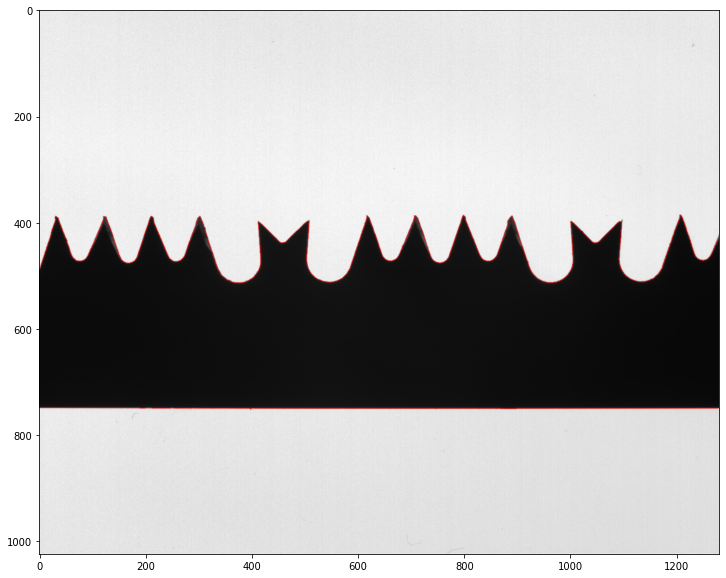

True

In [144]:
# CONVOLUTE BY A SMALL KERNEL TO FILTER NOISE (should improve results. See "Otsu's Binarization " chapter at https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html). Though it's best to not do this if the main goal is finding small blurs on the teeth blades
img_filtered = cv2.GaussianBlur(img,(5,5),0) #img
cv2.imwrite('logs/0_filtered.png', img_filtered)

# BINARIZATION
treshVal, img_bin = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_OTSU) #0 treshold val ignored since automatic threshold mode. Documentation: https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57
print("Chosen treshold value: ",treshVal)
cv2.imwrite('logs/1_1_binarized.png', cv2.cvtColor(img_bin,cv2.COLOR_GRAY2BGR))

# GET CONTOUR POINTS
inverted_img_bin=cv2.bitwise_not(img_bin) #from documentation: In OpenCV, finding contours is like finding white object from black background. So remember, object to be found should be white and background should be black. (https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html)
_img, contours, _hierarchy = cv2.findContours(image=inverted_img_bin, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE) #Documentation: https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a
# cv2.RETR_EXTERNAL: retrieves only the extreme outer contours
# cv2.CHAIN_APPROX_NONE: stores absolutely all the contour points. That is, any 2 subsequent points (x1,y1) and (x2,y2) of the contour will be either horizontal, vertical or diagonal neighbors, that is, max(abs(x1-x2),abs(y2-y1))==1
contour=contours[0]             # contours= max(contours, key=cv2.contourArea) # find the biggest countour by the area

# DRAW CONTOURS ON THE ORIGINAL IMAGE
img_points = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image=img_points, contours=[contour], contourIdx=-1, color=(0, 0, 255), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images

# DISPLAY CONTOURS ON THE ORIGINAL IMAGE
plt.figure(figsize=(20, 10))
image_rgb = cv2.cvtColor(img_points,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
plt.show()
#cv2.imwrite('test.png', img_points)
cv2.imwrite('logs/2_1_contours.png', cv2.cvtColor(image_rgb,cv2.COLOR_RGB2BGR))

## Applying Ramer-Douglas-Peucker algorithm

The distinction between linear and circular components will be carried out thanks to Ramer-Douglas-Peucker algorithm. The algorithm approximates the curve into a set of lines: shorter lines are likely to be part of circular arcs, whereas longer lines are probably part of a rectilinear component.

We will address the problem of how to distinguish teeth from circular arcs later. Right now we need to transform the contour of the entire object into a more suitable curve which can be fed to the [*cv2.approxPolyDP()*](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c) function (which is basically the OpenCV implementation of Douglas algorithm).

First, we need to adapt the series of points returned from *cv2.findContours()*, since it starts from the first point seen from top to bottom. Also, it continues counterclockwise. To Obtain consistent behaviour, we make the series start from the leftmost points (and - among these - the topmost one), and cut the series at the rightmost points (again - among these - the topmost one). We are interested in getting the contour between those 2 points. For that, we define a dedicated function called *selectContour()*.

Finally, we apply Douglas-Peucker algorithm with a fairly small epsilon value (*APPROX_POLY_DP_EPSILON*). It doesn't matter if the whole teeth side is not included into a single segment, we'll deal with that later, but they should be substantially longer than the others.



In [145]:
#DEFINE A FUNCTION CAPABLE OF SLICING THE CONTOUR CLOSED LINE INTO A PARTITION OF THAT CONTOUR (BY SPECIFYING START AND FINISH POINTS)
def selectContour(contour, startPoint, finishPoint): #startPoint and finishPoint should be distinct
    newContour=[]
    contourLen=contour.shape[0]
    i=0
    startPointIndex=-1
    finisPointIndex=-1
    exit=False
    stage=0 #0=find the startpoint
    while not exit:
        #Stage 0: find the start element
        if stage==0:
            if np.array_equal(contour[i,0],np.array(startPoint)):
                print("Start point ",startPoint," found, index ", i)
                startPointIndex=i
                stage=stage+1
                i=i+1
                i=i%contourLen #automatically restart series if it was the last point (closed shape)
            elif i==contourLen-1:
                raise Exception("selectContour(): Start point {} could not be found among contour points!".format(startPoint))
        #Stage 1: find the finish element (do that and then accumulate: first check his existence!)
        if stage==1:
            if i==startPointIndex:
                raise Exception("selectContour(): Finish point {} could not be found among contour points!".format(finishPoint))
            elif np.array_equal(contour[i,0],np.array(finishPoint)):
                print("Finish point ",finishPoint," found, index ", i)
                finisPointIndex=i
                stage=stage+1
                i=startPointIndex
        #Stage 2: accumulate points in a new vector
        if stage==2:
            newContour.append(contour[i])
            if i==finisPointIndex:
                exit=True
        i=i+1
        i=i%contourLen #automatically restart series if it was the last point (closed shape)
    return np.array(newContour)

#TEST THE FUNCTION:
#contour=np.array(
#    [[[1199,422]],
#     [[1198,423]],
#     [[1198,424]],
#     [[1201,423]],
#     [[1201,422]],
#     [[1200,422]]])
#contour = selectContour(contour, (1199,422), (1198,423)) #Should return the 2 elements only
#contour = selectContour(contour, (1201,422), (1200,422)) #Should return the 2 elements only
#contour = selectContour(contour, (1200,422), (1199,422)) #Should return the 2 elements only
#contour = selectContour(contour, (1199,422), (1200,422)) #Should return all the series as it was
#contour = selectContour(contour, (1201,423), (1198,424)) #Should return all the series from 4th to 3th
#contour = selectContour(contour, (1201,422), (1198,423)) #Should return all the series from 5th to 2nd
#contour = selectContour(contour, (1801,422), (1198,423)) #Should throw an error for the start point
#contour = selectContour(contour, (1201,422), (1188,423)) #Should throw an error for the end point
#for i in contour:
#    print(i)

Start point  (0, 487)  found, index  2002
Finish point  (1279, 428)  found, index  141


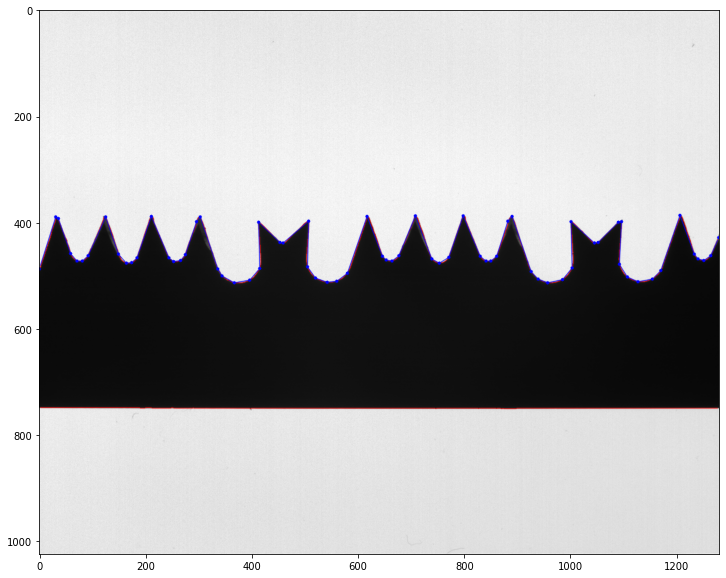

True

In [146]:
#REORDER THE POINT IN CLOCKWISE DIRECTION
f_contour=np.flip(contour,0)

#CALCULATE THE START AND FINISH POINT FOR THE PORTION OF THE CONTOUR WE HAVE TO ASSES
startXPoint = min(f_contour[:,0,0]) #get the minimum X value among all the contour points
startYPoint = min([pt[0,1] for pt in f_contour if pt[0,0]==startXPoint]) #get all the points with that minimum X value, then for each of them save the Y coordinate only. Finally, get the lowest Y coordinate
startPoint = (startXPoint,startYPoint)
finishXPoint = max(f_contour[:,0,0]) #get the maximum X value among all the contour points
finishYPoint = min([pt[0,1] for pt in f_contour if pt[0,0]==finishXPoint]) #get all the points with that maximum X value, then for each of them save the Y coordinate only. Finally, get the lowest Y coordinate
finishPoint = (finishXPoint,finishYPoint)

#SLICE THE CONTOUR
slicedContour = selectContour(f_contour, startPoint, finishPoint)

#APPROXIMATE THE SLICED CONTOUR INTO LIENS USING Ramer-Douglas-Peucker ALGORITHM
RDP_contour = cv2.approxPolyDP(slicedContour, APPROX_POLY_DP_EPSILON, False)

img_approx_lines = img_points.copy() #cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
#cv2.drawContours(image=img_approx_lines, contours=[RDP_contour], contourIdx=-1, color=(255, 0, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
cv2.polylines(img=img_approx_lines, pts=[RDP_contour], isClosed=False, color=(255, 0, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
for pt in RDP_contour[:,0]:
    cv2.circle(img=img_approx_lines, center=tuple(pt), radius=0, color=(255, 0, 0), thickness=5)

# Display Image
plt.figure(figsize=(20, 10))
image_rgb = cv2.cvtColor(img_approx_lines,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
plt.show()
cv2.imwrite('logs/2_2_approximated_contours.png', cv2.cvtColor(image_rgb,cv2.COLOR_RGB2BGR))

## Separation of connected components

So now we need to separate the teeth from each other.
Let's try to keep things organized by introducing a data model structure teeth with all the pieces of information in a hierarchical structure.

In [147]:
#    teeth
#    ├── left
#    │   ├── segments
#    │   └── contour
#    └── right
#        ├── segments
#        └── contour

#Just to show what we mean by that let's show how we are going to build this:

side = { #tooth side
      "segments": [], #segments of the tooth side. Shape: (npoints, 1, 2)
      "contour": [], #list of points creating the overall rectilinear side. Shape: (npoints, 1, 2)
}

tooth =	{ #single tooth (left+right side)
      "left": side, #teeth side
      "right": side, #teeth side
}

teeth = [] #list of tooth

Let's define a few utility functions:

In [148]:
#calculate distance between points
def distance(pointA,pointB):
    return cv2.norm(pointA-pointB)

#Get the border points between 2 given points (extremes included). It's basically an optimized version of selectContour() (queries are supposed to be subsequent, so we explore the array starting from the last position)
#outputs a numpy array of shape (npoints, 1, 2)
#ATTENTION: loops forever if the first point doesn't exist
_border_points_between_lastindex=0
_border_points_between_pointSeries=slicedContour
def border_points_between(pointA,pointB):
    global _border_points_between_lastindex
    global _border_points_between_pointSeries
    newContour=[]
    i=_border_points_between_lastindex #restart from where we left last time, for efficiency reasons
    NPoints=_border_points_between_pointSeries.shape[0]
    exit=False
    stage=0; #0=searching start, #1=accumulating and searching end
    while not exit:
        #Stage 0: find the start element
        if stage==0:
            if np.array_equal(_border_points_between_pointSeries[i,0],np.array(pointA)):
                stage=stage+1
        #Stage 1: accumulate points in a new vector till the end point is reached
        if stage==1:
            newContour.append(_border_points_between_pointSeries[i])
            if np.array_equal(_border_points_between_pointSeries[i,0],np.array(pointB)):
                _border_points_between_lastindex=i
                exit=True
            elif i>=NPoints-1:
                raise Exception("border_points_between(): End point {} could not be found after startpoint {} !".format(pointB, pointA))
        i=i+1
        i=i%NPoints
    return np.array(newContour)

#calculate the Δy/Δx ratio
def slope(pointA,pointB):
    return -(pointB[1]-pointA[1])/(pointB[0]-pointA[0]) #N.B: image y coordinates are inverted!

#calculate if the line is rising or decreasing (not the same as slope, the returned value is positive even if the line goes up-left)
def yDirection(pointA,pointB):
    return -(pointB[1]-pointA[1]) #N.B: image y coordinates are inverted!

#test
#border_points_between(np.array([0,0]),np.array([0,1]))

Now the goal is to take the segments in *RDP_contour* and insert them in the *teeth* structure, specifically in *teeth[TEETH_NUM]['right'/'left']['segments']*.

To carry out this allocation task we use a while loop going through all the segments in *RDP_contour*. At each iteration we have the 2 points A and B identifying the segment:

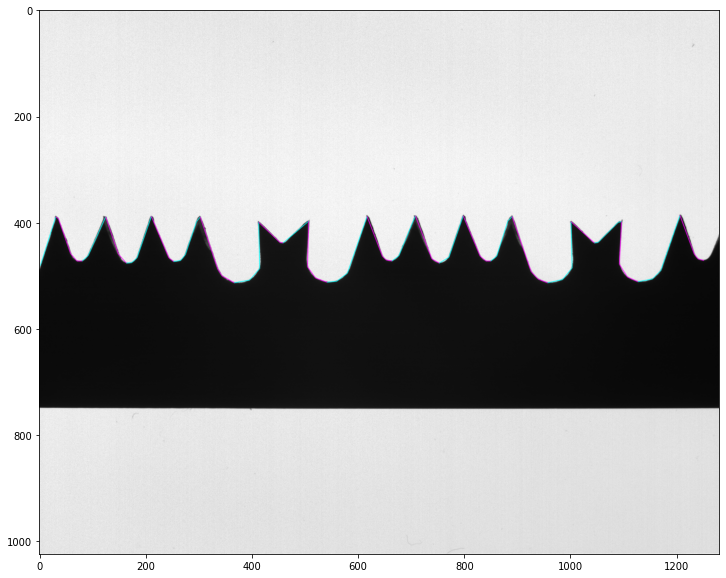

True

In [149]:
#PREPARE THE DATA STRUCTURE
def prepareLeftRightSides():
    global leftSide
    global rightSide
    leftSide={}
    leftSide['segments']=[]
    rightSide={}
    rightSide['segments']=[]
    
def saveSidesIntoTeeth():
    leftSide['segments']=np.array(leftSide['segments'])
    rightSide['segments']=np.array(rightSide['segments'])
    tooth = {}
    tooth['left']=leftSide
    tooth['right']=rightSide
    teeth.append(tooth)
    
teeth = []
prepareLeftRightSides()

#SPLIT INTO TEETH AND ASSIGN THE SEGMENTS TO THEM
state=0  #0: rising segment (=left side), 1: falling segment (=right side), 2: end of tooth - save data and go to 0
SegmentPtA=RDP_contour[0][0]
reiterate_current_segment=False
i=1
while i<RDP_contour.shape[0]:
    SegmentPtB=RDP_contour[i][0]
    yDir = yDirection(SegmentPtA,SegmentPtB) #rising if >0, falling if <0
    
    if state==0: #ready to process a new teeth: wait for the first rising segment (note: we alwais start with a left segment, there is no point to work on a teeth whose tip is out of frame!)
        if yDir>0:
            leftSide['segments'].append([SegmentPtA])
            leftSide['segments'].append([SegmentPtB])
            state=1 #we found the first segment of the new tooth: go on with the processing
            
    elif state==1: #we found the first segment of the new tooth, now we just need to find it's end by finding the first segment pointing downwards
        if yDir>=0:
            leftSide['segments'].append([SegmentPtB]) #N.B: if we just swiched to state 1, this is the same SegmentPtB of state 0 (note the elif!)
        else: #yDir<0:
            #tooth_tip=SegmentPtA
            rightSide['segments'].append([SegmentPtA])
            rightSide['segments'].append([SegmentPtB])
            if i>=RDP_contour.shape[0]-1: #this is going to be the last segment of the whole series. Save the current right side of this teeth even if we didn't reached the next tooth and exit
                saveSidesIntoTeeth()
                break
            state=2 #we found the first segment of the right side of the tooth
    
    elif state==2: #we found the the tip of the tooth, we now need to find the end of the right side of the tooth
        if yDir<=0:
            rightSide['segments'].append([SegmentPtB]) #N.B: if we just swiched to state 1, this is the same SegmentPtB of state 0 (note the elif!)
            if i>=RDP_contour.shape[0]-1: #this is going to be the last segment of the whole series. Save the current right side of this teeth even if we didn't reached the next tooth and exit
                saveSidesIntoTeeth()
                break
        if yDir>0: #this is the end of the right side
            #update the data structure
            saveSidesIntoTeeth()
            #reset structures for next tooth
            prepareLeftRightSides()
            #cicle start all over again
            state=0 #we found the end of the tooth, be ready for the start of the new one
            reiterate_current_segment=True #the current segment might be the one to consider for the next state
            
    if reiterate_current_segment:
        reiterate_current_segment=False
    else:
        SegmentPtA=SegmentPtB
        i=i+1

#VISUALIZE THE RESULT
#function to display and return an image of the side segments of the teeth
def showSideSegments(teeth):
    img_teeth_sides = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for tooth in teeth:
        #print(border_of_sides)
        cv2.polylines(img=img_teeth_sides, pts=[tooth['left']['segments']], isClosed=False, color=(255, 255, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
        cv2.polylines(img=img_teeth_sides, pts=[tooth['right']['segments']], isClosed=False, color=(255, 0, 255), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images

    # Display Image
    plt.figure(figsize=(20, 10))
    image_rgb = cv2.cvtColor(img_teeth_sides,cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    #plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
    plt.show()
    return image_rgb

image_rgb=showSideSegments(teeth)
cv2.imwrite('logs/3_1_teeth_sides.png', cv2.cvtColor(image_rgb,cv2.COLOR_RGB2BGR))  

## Filtering out segment belonging to circular arcs

Now we need to keep only the portion of the teeth side which is rectilinear. This is fairly simple, as we can just ignore shorter segments. The logic here is slightly more complicated, which will hopefully deliver us more accurate measurements. Consider a curve (belonging to a teeth side). We "erode" (i.e. remove) segments shorter than a certain threshold, starting from the base and moving our way up. We continue to erode until we don't find a long enough segment, which we will consider the beginning of our tooth.

#### *Choosing TEETH_SEGMENT_LEN_THRESH*
We have to establish a suitable threshold for filtering out segments belonging to arcs. Having a look at the lengths distribution of the segments, we can see that a suitable value for it should range between 40/50 pixels (see also se same diagram on all the images [here](/notebooks/Analyze_all.ipynb)). We assume that the blades do not change in size, so a static constant is ok. We tend to chose a small value, it's better to pich a few more segments belonging to the ark at the base (losing some precision...) rather than risking to not pick any and fail to detect the tooh! 
Keeping that in mind, we set the chosen value into the *TEETH_SEGMENT_LEN_THRESH* constant (see first code block).

In [150]:
lengths=[]
SegmentPtA=RDP_contour[0][0]
i=1
while i<RDP_contour.shape[0]:
    SegmentPtB=RDP_contour[i][0]
    length=distance(SegmentPtA,SegmentPtB)
    lengths.append(length)
    SegmentPtA=SegmentPtB
    i=i+1

# Compute frequency and bins
frequency, bins = np.histogram(lengths, bins=20, range=[0, 100])
# Pretty Print
for b, f in zip(bins[1:], frequency):
    print(round(b, 1), ' '.join(np.repeat('*', f)))

5.0 
10.0 * * * * * *
15.0 * * * * * * * * * * * * * *
20.0 * * * * * * * *
25.0 * * * * *
30.0 * * * * * * * * *
35.0 
40.0 *
45.0 
50.0 
55.0 *
60.0 * *
65.0 *
70.0 * * *
75.0 *
80.0 *
85.0 * * * * * * * *
90.0 * * * *
95.0 
100.0 


Erode the sides, and delete the teeth with sides that have no points left:

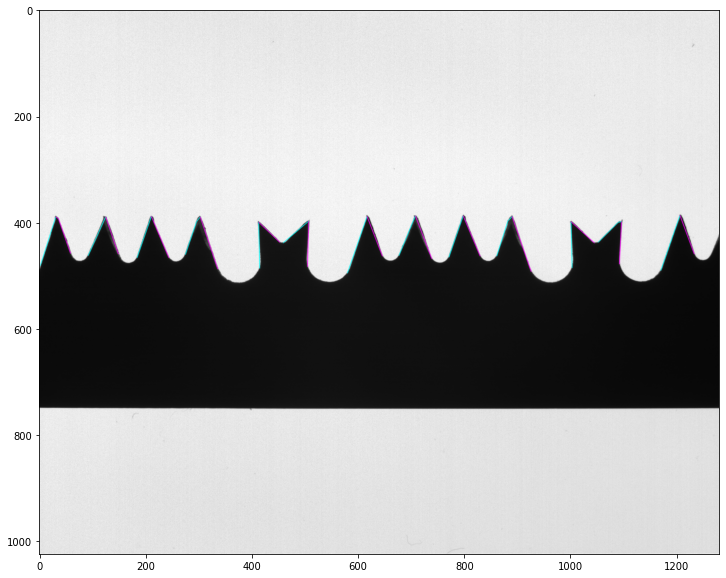

True

In [151]:
def erodeLeftSide(segments,threshold):
    SegmentPtA=segments[0][0]
    i=1
    foundLongSegment=False
    newSegments=[]
    while i<len(segments):
        SegmentPtB=segments[i][0]
        if foundLongSegment==False: #if we didn't yet found any long segment, check if the current one is long enought, otherwise this check is useless
            if distance(SegmentPtA,SegmentPtB)>threshold:
                foundLongSegment = True
                newSegments.append([SegmentPtA]) #as this is the fist segment being added, we also need to add point A. Point B will be added with the next if block
        if foundLongSegment==True: #if we already found a long segment keep adding segments (B point) till the end
            newSegments.append(segments[i])
        SegmentPtA=SegmentPtB
        i=i+1
    return np.array(newSegments)

def erodeRightSide(segments,threshold):
    #do the same thig, but in reverse
    segments=np.flip(segments,0)
    segments=erodeLeftSide(segments,threshold)
    return np.flip(segments,0)
        
#TEST THE FUNCTION
#relDistances=[1,9,1,9,1] #both should erode the first point only
#relDistances=[1,9,1,9] #left should filter first point only, right keeps it untouched
#relDistances=[9,1,9,1] #right should filter last point only, left keeps it untouched
#segment=[]
#segment.append([[0,0]])
#acc=0
#for val in relDistances:
#    acc=acc+val
#    segment.append([[acc,0]])
#segment=np.array(segment)
#print(segment)
#print(erodeLeftSide(segment,5))
#print(erodeRightSide(segment,5))

#FILTER SEGMENTS IN THE DATA STRUCTURE
#Note: technically for the following computations all we would really need are just the start point of the teeth on the 2 sides and the tip point (where segments change in direction)
for tooth in teeth:
    tooth['left']['segments']=erodeLeftSide(tooth['left']['segments'],TEETH_SEGMENT_LEN_THRESH)
    tooth['right']['segments']=erodeRightSide(tooth['right']['segments'],TEETH_SEGMENT_LEN_THRESH)
    
#REMOVE TEETH WITH NO SIDES LEFT
#the previous filtering step might have removed all the segments of a side
#(maybe one of the teeth side was almost out of frame, so the segment would be much shorter than normal)
#so in that case remove the whole tooth (this is ok event in the case highlited above: too short side segments would produse imprecise results)
newTeeth=[]
for tooth in teeth:
    if len(tooth['left']['segments'])>=2 and len(tooth['right']['segments'])>=2: #segments have at leas 2 points
        newTeeth.append(tooth)
teeth=newTeeth

#VISUALIZE THE RESULT
image_rgb=showSideSegments(teeth)
cv2.imwrite('logs/4_1_filter_out_arcs.png', cv2.cvtColor(image_rgb,cv2.COLOR_RGB2BGR))  

Now, what we actually need are  the contour points corresponding to the segments, rather than the segments themselves.
This is because we will later fit the best line approximating these points using a least-squares algorithm.

In [152]:
#EXTRACT THE CONTOURS
for tooth in teeth:
    tooth['left']['contour']=border_points_between(tooth['left']['segments'][0][0],tooth['left']['segments'][-1][0])
    tooth['right']['contour']=border_points_between(tooth['right']['segments'][0][0],tooth['right']['segments'][-1][0])

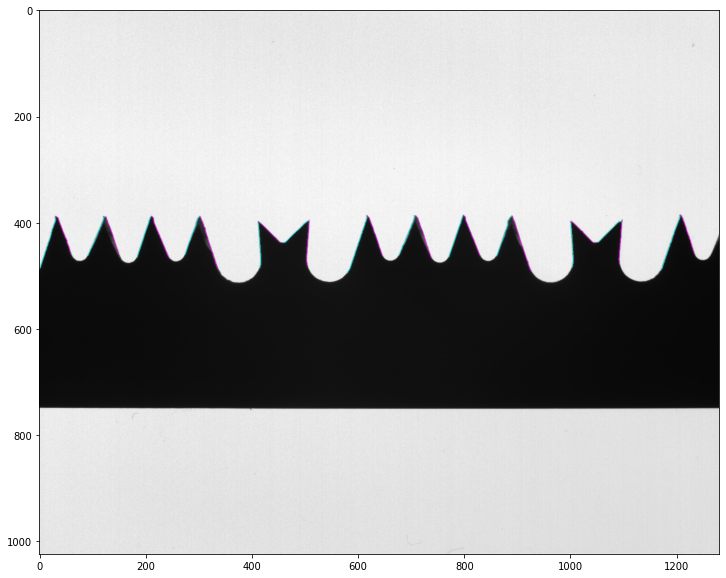

True

In [153]:
#SHOW THE RESULT
img_teeth_sides = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for tooth in teeth:
    #print(border_of_sides)
    cv2.polylines(img=img_teeth_sides, pts=[tooth['left']['contour']], isClosed=False, color=(255, 255, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
    cv2.polylines(img=img_teeth_sides, pts=[tooth['right']['contour']], isClosed=False, color=(255, 0, 255), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images

# Display Image
plt.figure(figsize=(20, 10))
image_rgb = cv2.cvtColor(img_teeth_sides,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
plt.show()

#VISUALIZE THE RESULT
cv2.imwrite('logs/4_2_teeth_contours.png', cv2.cvtColor(image_rgb,cv2.COLOR_RGB2BGR))  

## Make the measurements
Now we want to get the approximating line equation out of all the teeth sides. 
This comes down to finding the line parameters capable of minimizing the average distance between all the points and the line.

Luckily OpenCV already has the [fitLine()](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gaf849da1fdafa67ee84b1e9a23b93f91f) function which is specific for this task. Basically if finds the line parameters minimizing $\sum_{i} r_i^2$, where $r_i$ is a distance between the point and the line.

But first, let's define a few utility functions

In [154]:
#just some utility functions to calculate intersection between lines, angles between objects, etc...
#line equation of the type y=(Δy/Δx)x+c=mx+c

#@@@@@@@@@@@@@@@@@@@@@ LINES @@@@@@@@@@@@@@@@@@@@
#calculate the function value at x given the line parameters slope (m) and intercept (c)
def getY(m,c,x):
    return m*x+c

#calculate the C constant giving a point of the line (x,y) and his slope (m)
def getIntercept(x,y,m):
    return y-m*x
    
#calculate the intersection point of two lines given theier slop (m1, m2) and intercept (c1, c2)
def intersection_pt(m1, c1, m2, c2):
    x=-(c1-c2)/(m1-m2)
    y=m1*x+c1
    return [x,y]

#calculate the intersection point of two lines defined by a collinear to the line (vx, vy) and a point of the line (x0,y0)
def intersection_pt_cvlines(vx1,vy1,x01,y01,vx2,vy2,x02,y02):
    #lets handle some special cases first
    if vx1==0: #1st line slope would be infinite (Δx1=0): simply calculate y using 2nd line equation in the x on which lies the 1st (vertical) line
        x=x01
        y=getY(vy2/vx2,getIntercept(x02,y02,vy2/vx2),x)
        return [x,y]
    elif vx2==0: #2nd line slope would be infinite (Δx2=0): simply calculate y using 1st line equation in the x on which lies the 2nd (vertical) line
        x=x02
        y=getY(vy1/vx1,getIntercept(x01,y01,vy1/vx1),x)
        return [x,y]
    else:
        c1=getIntercept(x01,y01,vy1/vx1)
        m1=vy1/vx1
        c2=getIntercept(x02,y02,vy2/vx2)
        m2=vy2/vx2
        return intersection_pt(m1,c1,m2,c2)

#intersection_pt_cvlines(0,0.5,2,2,0.5,1,-1,-1) #[2, 5]
#intersection_pt_cvlines(2,1,1,1,1,2,3,0) #[4.33, 2.66]

#@@@@@@@@@@@@@@@@@@@@ ANGLES @@@@@@@@@@@@@@@@@@@@
def rad2deg(rad):
    return rad/math.pi*180
def getSideAngle(vx,vy): #[0,+90] if it points down-right, ]0,-90] if down-left
    #if a vector points upward, invert a vector so that vercors that are pointing to I and II quadrants now points respectively to III and IIII ones (basically it roates them by 180° if needed)
    if vy>0:
        vx,vy=-vx,-vy
    if vx<0: #down-left
        return -(+90-rad2deg(math.atan(vy/vx))) # (atan>=0)
    else: #down-right
        return +90+rad2deg(math.atan(vy/vx)) #(atan<=0)
    
#@@@@@@@@@@@@@@@@@@@@ PERPENDICULAR LINE given a line and a point @@@@@@@@@@@@@@@@@@@
#this is useful to trace the segments approximating the sides of each tooth, specifically to make them of the right length
#get the "m" and "c" values for a line passing through "(x,y)" and perpendicular to another line of slope "m"
def perpendicularLine(x,y,m):
    newm=-1/m
    return [newm,y-newm*x]

#given a line defined by "vx","vy","x","y" and a point defined by "j","k", get the point of the line with the minimum distance to point (j,k)
def closestLinePt(vx,vy,x0,y0,j,k):
    #lets handle some special cases first
    if vx==0: #since the line is vertical take the the x coordinate of a point of the line ("x0"), and the y coordinate of the other point ("k")
        return [x0,k]
    elif vy==0: #since the horizontal take the the y coordinate of a point of the line ("y0"), and the x coordinate of the other point ("j")
        return [j,y0]
    else: #closest point is the intersection of the line and the perpendicular line passing through (j,k)
        m1=vy/vx
        c1=getIntercept(x0,y0,m1)
        m2,c2=perpendicularLine(j,k,m1)
        return intersection_pt(m1,c1,m2,c2)
    
#closestLinePt(1,3,-1,1,1,2)  [-0.5, 2.5]
#closestLinePt(1,0,-1,1,2,2)  [2, 1]
#closestLinePt(0,1,-1,1,2,2)  [-1, 2]

#@@@@@@@@@@@@@@@@@@ GENERAL @@@@@@@@@@@@@@@@@@
def roundIntPt(pt):
    return [round(pt[0]),round(pt[1])]

Let's now actually calculate the equation of the lines and angles between them. We will do that progressively enriching the data model structure. So far the *teeth* consists of a list of *tooth* whose structure looks like this:
* *'left'* and *'right'* sides of the tooth, each one consisting of: 
    * *segments*: teeth side segments approximating their contour
    * *contour*: teeth side contours points
    * *fitline_data*: raw fit data coming from *cv2.fitLine()*
    * *line_basepoint*: a point identifying the start of the approximating line segment
    * *angle*: angle of the line in degrees with respect to a vertical line
* *intersection*: the intersection point between the 2 approximating lines of the side 
* *angle*: the angle between the 2 approximating lines of the side    

In [155]:
for tooth in teeth:
    tooth['left']['contour']=border_points_between(tooth['left']['segments'][0][0],tooth['left']['segments'][-1][0])
    tooth['right']['contour']=border_points_between(tooth['right']['segments'][0][0],tooth['right']['segments'][-1][0])
    
    tooth['left']['fitline_data']=cv2.fitLine(tooth['left']['contour'],cv2.DIST_L2,0,0.01,0.01)
    vx1,vy1,x01,y01=tuple(tooth['left']['fitline_data'].flatten())
    firstBorderPt=tooth['left']['contour'][0][0]
    firstLinePt=closestLinePt(vx1,vy1,x01,y01,firstBorderPt[0],firstBorderPt[1])
    tooth['left']['line_basepoint']=roundIntPt(firstLinePt)
    tooth['left']['angle']=getSideAngle(vx1,-vy1)
    
    tooth['right']['fitline_data']=cv2.fitLine(tooth['right']['contour'],cv2.DIST_L2,0,0.01,0.01)
    vx2,vy2,x02,y02=tuple(tooth['right']['fitline_data'].flatten())
    lastBorderPt=tooth['right']['contour'][-1][0]
    lastLinePt=closestLinePt(vx2,vy2,x02,y02,lastBorderPt[0],lastBorderPt[1])
    tooth['right']['line_basepoint']=roundIntPt(lastLinePt)
    tooth['right']['angle']=getSideAngle(vx2,-vy2)
    
    tooth['intersection']=intersection_pt_cvlines(vx1,vy1,x01,y01,vx2,vy2,x02,y02)
    tooth['angle']=abs(tooth['left']['angle']-tooth['right']['angle'])

## Overlay data onto the image

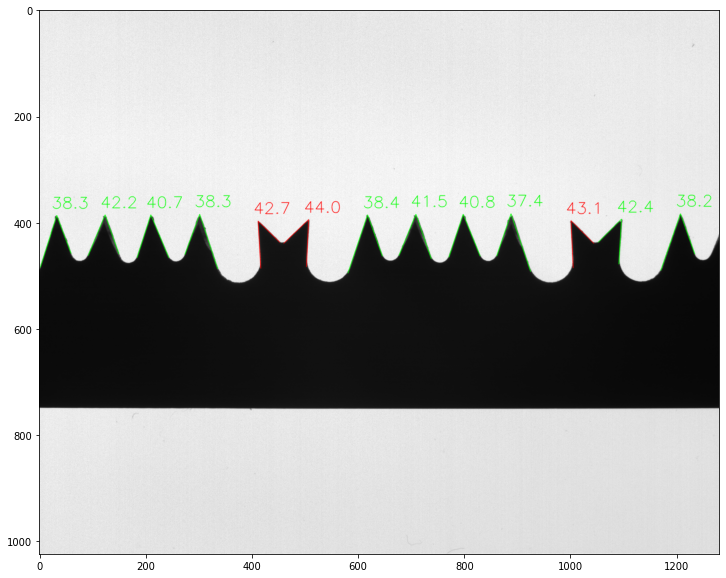

True

In [156]:
R=(37.0,42.5) #allowable_angle_range
overlay_colors = {
  "red": (0, 0, 255),
  "green": (0, 255, 0)
}

#overlay on a new image the relevant data
def overlay_teeth_data(img_to_overlay):
    for tooth in teeth:
        if tooth['angle']>=R[0] and tooth['angle']<=R[1]:
            color="green"
        else:
            color="red"
        color=overlay_colors[color]
        angleText=str(round(tooth['angle'],1))
        textPos=(round(tooth['intersection'][0]-10),round(tooth['intersection'][1]-14))
        img_to_overlay = cv2.putText(img=img_to_overlay, text=angleText, org=textPos, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=color, thickness=1, lineType=cv2.LINE_AA)
        cv2.line(img_to_overlay, tuple(tooth['left']['line_basepoint']), tuple(tooth['intersection']), color=color, thickness=1, lineType=cv2.LINE_AA)
        cv2.line(img_to_overlay, tuple(tooth['right']['line_basepoint']), tuple(tooth['intersection']), color=color, thickness=1, lineType=cv2.LINE_AA)
    return img_to_overlay

img_overlayed = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img_overlayed=overlay_teeth_data(img_overlayed)

# Display Image
plt.figure(figsize=(20, 10))
image_rgb = cv2.cvtColor(img_overlayed,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite('final_result.png', img_overlayed)

## Optional requirement
So we need to detect points of the teeth edge that deviates more than 5 pixels from the approximating line.
Basically, the only thing we need to do for each point of the teeth contour in *tooth['left'/'right']['contour']* is:
1. Calculate the closest point projecting on the line tooth['left']['fitline_data']. We can do that with previously defined utility function *closestLinePt(vx,vy,x0,y0,j,k)*
2. Calculate the distance between the segment point and the line point just found. We can do that with previously defined utility function *distance(pointA,pointB)*
3. check if it's > *DIST_THRESH* (=5). If it is, overlay a red point on the image at contour point position


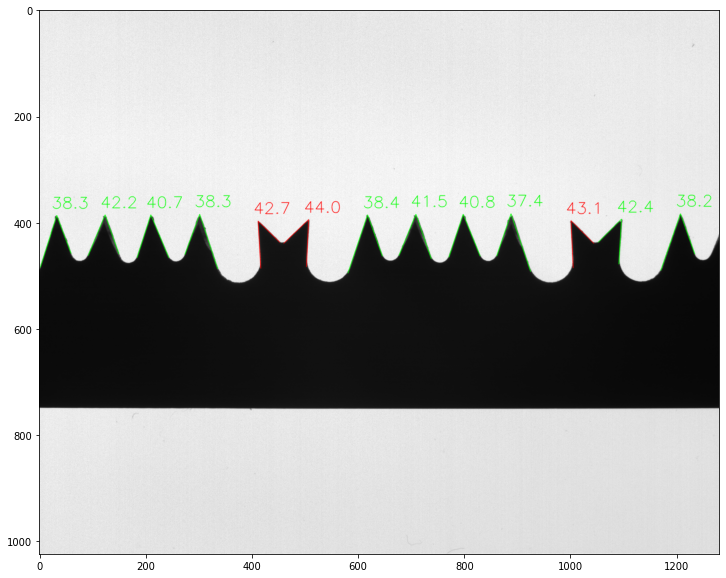

True

In [160]:
DIST_THRESH = 5 #1
OVERLAY_COLOR = (0, 128, 255) #ORANGE

foundBurrs=False

img_overlayed_imperfections = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img_surround = np.zeros((img_overlayed_imperfections.shape[0],img_overlayed_imperfections.shape[1],1), dtype=np.uint8) #np.zeros_like(img_overlayed_imperfections)
for tooth in teeth:
    for side in ('left','right'):
        for contourPt in tooth[side]['contour']:
            foundBurrsInSegment=False
            vx,vy,x0,y0=tooth[side]['fitline_data'].flatten()
            cx,cy=contourPt[0]
            lx,ly=closestLinePt(vx,vy,x0,y0,cx,cy)
            dist=distance(np.array([cx,cy]),np.array([lx,ly]))
            if(dist>DIST_THRESH):
                img_overlayed_imperfections=cv2.circle(img=img_overlayed_imperfections, center=tuple([cx,cy]), radius=0, color=OVERLAY_COLOR, thickness=1)
                img_surround=cv2.circle(img=img_surround, center=tuple([cx,cy]), radius=0, color=(255, 255, 255), thickness=30)  #also make a big circle around the point to highlight it. Agglomerate circles on case of close points
                #print("burr detected at contour point ({},{})".format(cx,cy))
                foundBurrsInSegment=True
                foundBurrs=True
        if foundBurrsInSegment:
            _img, contours, _hierarchy = cv2.findContours(image=img_surround, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
            cv2.drawContours(image=img_overlayed_imperfections, contours=contours, contourIdx=-1, color=OVERLAY_COLOR, thickness=3, lineType=cv2.LINE_AA)      
            img_surround.fill(0) #reset tmp image

if foundBurrs==False:
    print('WARNING: no burr with distance > {} have been found. Try a smaller value!'.format(DIST_THRESH))
img_overlayed_imperfections=overlay_teeth_data(img_overlayed_imperfections) #overlay approximating segments and angle information ON the current one


# Display Image
plt.figure(figsize=(20, 10))
image_rgb = cv2.cvtColor(img_overlayed_imperfections,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite('final_result_highlighted_imperfections.png', img_overlayed_imperfections)


# OLD VERSIONS AND OTHER SNIPPETS OF CODE
## YOU CAN IGNORE THIS SECTION from here onwards

La distinzione avviene utilizzando l'algoritmo Ramer-Douglas-Peucker: se una determinata porzione di bordo viene approssimata da un segmento più lungo di _teeth_segment_len_, i punti di quella porzione (i punti del bordo compresi tra i due estremi del segmento approssimato) vengono considerati come punti appartenenti ad una linea di un dente. Viceversa segmenti più corti di _teeth_segment_len_ potrebbero essere non considerati facenti parti di un dente ma di un arco circolare.
Più nello specifico, una porzione di bordo approssimato da un segmento corto viene comunue considerato come porzione di dente se si trova:
- dopo una porzione considerata come linea di un dente e prima della punta del dente (ovvero l'estremo del prossimo segmento con pendenza <= 0)
- dopo la punta del dente e prima dell'ultimo segmento considerato linea del dente (ovvero si parte dall'ultimo semgmento che ancora ha pendenza <0, e da qui si va a ritroso e si trova il primo ad avere lunghezza > _teeth_segment_len_)

The goal is to obtain a data structure whose hirarchy is the following:
- 1st dimension: tooth number. an unknown number of teeth will be computed
- 2nd dimension: consist of the left (index 0) and right (index 1) side of the tooth. Only teeth with both sides will be computed.
- 3rd and diemnsion: numpy array with the points of the border (shape: (npoints, 1, 2)) 

In [39]:
teeth_segment_len=TEETH_SEGMENT_LEN_THRESH
teeth_contours = RDP_contour

sides_of_teeth=[]
border_of_sides=[]

state=0
reiterate_current_segment=False
approx_point_a=teeth_contours[0][0]
first_tooth_side_point=None
last_tooth_side_point=None
i=0
while i<teeth_contours.shape[0]:
    approx_point_b=teeth_contours[i][0]
    #print(distance(approx_point_a,approx_point_b))
    
    if state==0: #ready to process a new teeth: wait for the first rising segment whose length is > teeth_segment_len
        if yDirection(approx_point_a,approx_point_b)>0 and distance(approx_point_a,approx_point_b)>teeth_segment_len:
            first_tooth_side_point=approx_point_a
            state=1 #we found the first segment of the new tooth: go on with the processing
            border_of_sides=[]
    
    elif state==1: #we found the first segment of the new tooth, now we just need to find it's end by finding the first segment pointing downwards
        if yDirection(approx_point_a,approx_point_b)<0:
            tooth_tip=approx_point_a
            side_points=border_points_between(first_tooth_side_point,tooth_tip)
            #print("left side: " + str(first_tooth_side_point) + "-" + str(tooth_tip) + "[" + str(side_points.flatten()) + "]")
            border_of_sides.append(side_points)
            state=2
            last_tooth_side_point=None
            reiterate_current_segment=True #the current segment might be the one to consider for the next state
    
    elif state==2: #we found the the tip of the tooth, we now need to find the end of the right side of the tooth
        #the end point of the right side is the last pointing down segment which have length > teeth_segment_len
        if yDirection(approx_point_a,approx_point_b)<0: #may or may not be part of the right side of tooth (N.B: this cant be part of a new tooth)
            if distance(approx_point_a,approx_point_b)>teeth_segment_len: #if the segment have length > teeth_segment_len, it's still a tooth segment: save it's extreme in case it's the last one
                last_tooth_side_point=approx_point_b #note: this should always happen during the first iteration
            if i==teeth_contours.shape[0]-1: #this will be the last point. Let's consider it as a valid end point
                last_tooth_side_point=approx_point_b
                side_points=border_points_between(tooth_tip,last_tooth_side_point)
                border_of_sides.append(side_points)
                sides_of_teeth.append(border_of_sides)
                border_of_sides=[]
                break #avoid execution of next else branch
        else: #by now we found the end of the tooth
            if(last_tooth_side_point is None): #theoretically this can only happen if pretty much all the right side of the last tooth is out of frame
                print("Warning: the application was unable to determine the end of the right side of the tooth: skipping tooth")
                state=0
            else:
                side_points=border_points_between(tooth_tip,last_tooth_side_point)
                border_of_sides.append(side_points)
                sides_of_teeth.append(border_of_sides)
                border_of_sides=[]
                #cicle start all over again
                state=0
                reiterate_current_segment=True #the current segment might be the one to consider fot the next state
            
            
    if reiterate_current_segment:
        reiterate_current_segment=False
    else:
        approx_point_a=approx_point_b
        i=i+1
print("ok")

ok


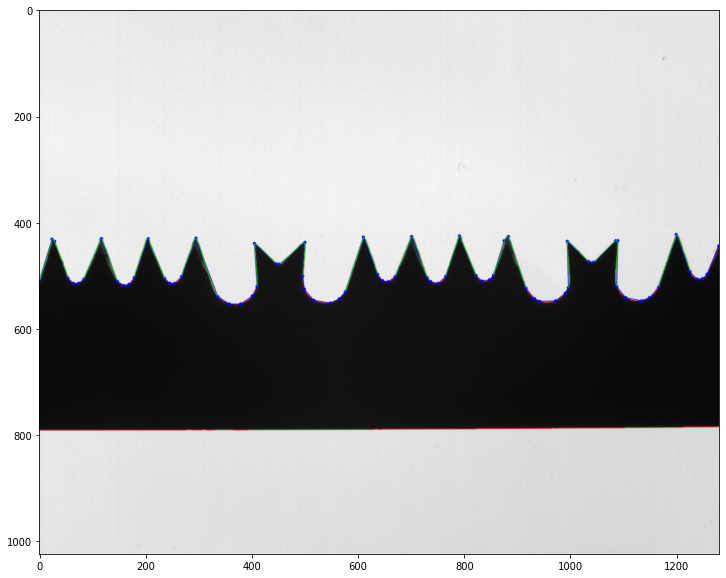

True

In [40]:
img_points3 = img_approx_lines.copy() #cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for border_of_sides in sides_of_teeth:
    #print(border_of_sides)
    cv2.polylines(img=img_points3, pts=[border_of_sides[0]], isClosed=False, color=(0, 255, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
    cv2.polylines(img=img_points3, pts=[border_of_sides[1]], isClosed=False, color=(0, 255, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
    
#for i in range(0,1):
#    #print(border_of_sides)
#    cv2.polylines(img=img_points3, pts=[sides_of_teeth[i][0]], isClosed=False, color=(0, 255, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
#    #cv2.polylines(img=img_points3, pts=[sides_of_teeth[i][1]], isClosed=False, color=(0, 255, 0), thickness=0, lineType=cv2.LINE_AA)  #note: set color to color=(255, 255, 255) if working with grayscale images
     
# Display Image
plt.figure(figsize=(20, 10))
image_rgb = cv2.cvtColor(img_points3,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite('test.png', img_points3)
    

Now we want to get the line equation out of all the segment. The goal is to obtain a data structure whose hirarchy is the following:
- 1st dimension: tooth number. an unknown number of teeth will be computed
- 2nd dimension: a list containing
    - At index 0 and 1 we have the left and right side of the tooth. This 
        - raw fit data coming from cv2.fitLine()
        - a medium point where to start tracing the segment
        - the angle of the line in degrees with respect to a vertical line
    - At index 2 the intersection point is available
    - At index 3 the angle between the points is available    

In [41]:
teeth=[]
tooth=[]

for border_of_sides in sides_of_teeth:
    
    leftSide=[]
    leftFitLine=cv2.fitLine(border_of_sides[0],cv2.DIST_L2,0,0.01,0.01)
    vx1,vy1,x01,y01=tuple(leftFitLine.flatten())
    leftSide.append(leftFitLine)
    firstBorderPt=border_of_sides[0][0][0]
    firstLinePt=closestLinePt(vx1,vy1,x01,y01,firstBorderPt[0],firstBorderPt[1])
    leftSide.append(roundIntPt(firstLinePt))
    #leftSide.append([x01,y01])
    leftAngle=getSideAngle(vx1,-vy1)
    leftSide.append(leftAngle)
    
    rightSide=[]
    rightFitLine=cv2.fitLine(border_of_sides[1],cv2.DIST_L2,0,0.01,0.01)
    vx2,vy2,x02,y02=tuple(rightFitLine.flatten())
    rightSide.append(rightFitLine)
    lastBorderPt=border_of_sides[1][len(border_of_sides[1])-1][0]
    lastLinePt=closestLinePt(vx2,vy2,x02,y02,lastBorderPt[0],lastBorderPt[1])
    rightSide.append(roundIntPt(lastLinePt))
    #rightSide.append([x02,y02])
    rightAngle=getSideAngle(vx2,-vy2)
    rightSide.append(rightAngle)
    
    #create the tooth and add it to the teeth
    tooth=[]
    tooth.append(leftSide)
    tooth.append(rightSide)
    tooth.append(intersection_pt_cvlines(vx1,vy1,x01,y01,vx2,vy2,x02,y02))
    tooth.append(abs(rightAngle-leftAngle))
    teeth.append(tooth)
    
#teeth

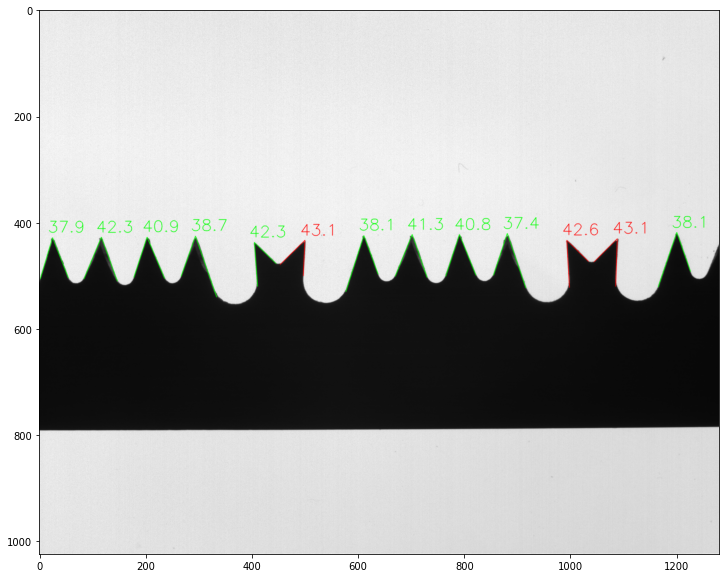

True

In [42]:
R=(37.0,42.5) #allowable_angle_range
overlay_colors = {
  "red": (0, 0, 255),
  "green": (0, 255, 0)
}

#overlay on a new image the relevant data
img_overlayed = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for tooth in teeth:
    if tooth[3]>=R[0] and tooth[3]<=R[1]:
        color="green"
    else:
        color="red"
    color=overlay_colors[color]
    angleText=str(round(tooth[3],1))
    textPos=(round(tooth[2][0]-10),round(tooth[2][1]-10))
    img_overlayed = cv2.putText(img=img_overlayed, text=angleText, org=textPos, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=color, thickness=1, lineType=cv2.LINE_AA)
    cv2.line(img_overlayed, tuple(tooth[0][1]), tuple(tooth[2]), color=color, thickness=1, lineType=cv2.LINE_AA)
    cv2.line(img_overlayed, tuple(tooth[1][1]), tuple(tooth[2]), color=color, thickness=1, lineType=cv2.LINE_AA)

# Display Image
plt.figure(figsize=(20, 10))
image_rgb = cv2.cvtColor(img_overlayed,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
#plt.imshow(img_points, cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite('test_ov.png', img_overlayed)

In [43]:
def erodeBySize(segments,threshold):
    segments=list(segments)
    NPoints=len(segments)
    SegmentPtA=segments[0][0]
    i=1
    while i<NPoints:
        SegmentPtB=segments[i][0]
        if distance(SegmentPtA,SegmentPtB)<=threshold:
            print("deleting ", segments[0])
            del segments[0]
            NPoints=NPoints-1
        else:
            break #stop eroding after we found the first long segment
        SegmentPtA=SegmentPtB
        #i=i+1 #DO NOT increase i: it we are here it's because we just deleted an element, so the next element is already the current index
    #do the same thig, but in reverse
    SegmentPtA=segments[NPoints-1][0]
    i=NPoints-2
    while i>0:
        SegmentPtB=segments[i][0]
        if distance(SegmentPtA,SegmentPtB)<=threshold:
            del segments[-1]
            NPoints=NPoints-1
        else:
            break #stop eroding after we found the first long segment
        SegmentPtA=SegmentPtB
        i=i-1
    return np.array(segments)
        
#TEST THE FUNCTION
#relDistances=[1,9,1,9,1] #should return only the 3 central points
#relDistances=[1,9,1,9] #should remore the first point only
#relDistances=[1,1,9,1,9] #should remore the first 2 points only
#relDistances=[9,1,9,1] #should remore the last point only
segment=[]
segment.append(np.array([[0,0]]))
acc=0
for val in relDistances:
    acc=acc+val
    segment.append(np.array([[acc,0]]))
print(segment)
print(erodeBySize(segment,5))

NameError: name 'relDistances' is not defined